This is the first part in what will hopefully be a series of notes [^fn] on my exploration of the recently released Google QuickDraw dataset, using the SketchRNN model that was released concurrently.

The QuickDraw dataset is ...

SketchRNN is a very impressive generative model that can learn to produce vector drawings. It is of particular interest to me because it cleverly combines many of the latest tools and techniques in machine learning, such as Variational Autoencoders, HyperLSTMs (a kind of HyperNetwork), Autoregressive models, Layer Normalization, Recurrent Dropout, the Adam optimizer, and others.

This notebook was based on ... Magenta only support Python 2 currently. I've made minor changes to ensure Python 3 compatibility.

[^fn]: These notes will likely be quite hasty and unpolished. It is written more for myself than anyone else. While I've always tried to avoid cluttering up my blog with notebooks on in-progress work, I've decided to just make a habit of posting them everytime I complete a session of work on something for the day. The aim is to start creating series of short and succinct notebooks, and avoid further accumulating a collection of long and disorganized notebooks that I never want to touch again, because the sheer effort of going through, cleaning up the experimental code, and articulating it effectively in a well-thought-out blog article just requires too much willpower. Doing it this way will hopefully make it much easier for me to create and share useful content quickly.

### Environment Set-up

Some preamble for plotting (I really ought to put these in a config file at some point...), and importing dependencies. I've made the imports here explicit so we know exactly what methods/objects are imported and can find the module from which they were imported more easily.

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import tensorflow as tf

from matplotlib.path import Path

In [5]:
from magenta.models.sketch_rnn.sketch_rnn_train import \
    (load_env,
     load_checkpoint,
     reset_graph,
     download_pretrained_models,
     PRETRAINED_MODELS_URL)
from magenta.models.sketch_rnn.model import Model, sample
from magenta.models.sketch_rnn.utils import (get_bounds, 
                                             to_big_strokes,
                                             to_normal_strokes)
# from magenta.models.sketch_rnn.rnn import *

In [6]:
# set numpy output to something sensible
np.set_printoptions(precision=8, 
                    edgeitems=6, 
                    linewidth=200, 
                    suppress=True)

In [7]:
tf.logging.info("TensorFlow Version: {}".format(tf.__version__))

INFO:tensorflow:TensorFlow Version: 1.1.0


### Getting the Pre-Trained Models and Data

In [8]:
DATA_DIR = ('http://github.com/hardmaru/sketch-rnn-datasets/'
            'raw/master/aaron_sheep/')
MODELS_ROOT_DIR = '/tmp/sketch_rnn/models'

In [9]:
PRETRAINED_MODELS_URL

'http://download.magenta.tensorflow.org/models/sketch_rnn.zip'

In [10]:
download_pretrained_models(
    models_root_dir=MODELS_ROOT_DIR,
    pretrained_models_url=PRETRAINED_MODELS_URL)

INFO:tensorflow:Downloading pretrained models from http://download.magenta.tensorflow.org/models/sketch_rnn.zip...
INFO:tensorflow:Download complete.
INFO:tensorflow:Unzipping /tmp/sketch_rnn/models/sketch_rnn.zip...
INFO:tensorflow:Unzipping complete.


The directory tree looks like this. There are a few pretrained models for us to explore. We look at the layer normalized model trained on the `aaron_sheep` dataset for now.

In [21]:
!tree -L 3 /tmp/sketch_rnn/

/tmp/sketch_rnn/
└── models
    ├── aaron_sheep
    │   ├── layer_norm
    │   ├── layer_norm_uncond
    │   ├── lstm
    │   └── lstm_uncond
    ├── catbus
    │   └── lstm
    ├── elephantpig
    │   └── lstm
    ├── flamingo
    │   └── lstm_uncond
    ├── owl
    │   └── lstm
    └── sketch_rnn.zip

14 directories, 1 file


In [22]:
MODEL_DIR = MODELS_ROOT_DIR + '/aaron_sheep/layer_norm'

In [23]:
(train_set, 
 valid_set, 
 test_set, 
 hps_model, 
 eval_hps_model, 
 sample_hps_model) = load_env(DATA_DIR, MODEL_DIR)

INFO:tensorflow:Downloading http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/aaron_sheep.npz
INFO:tensorflow:model_params.max_seq_len 250.
total images <= max_seq_len is 7400
total images <= max_seq_len is 300
total images <= max_seq_len is 300
INFO:tensorflow:normalizing_scale_factor 18.5198.


### Drawing the Dataset

The `strokes` object variable is the list of data points, which are sequences of strokes, represented as a 2D NumPy array of xy-offsets and the pen state.

In [78]:
len(train_set.strokes)

7400

We can get a random sample from the dataset like so

In [79]:
a = train_set.random_sample()
a.shape

(72, 3)

In the original notebook, the authors implemented their own function to iterate through a stroke sequence and write out a SVG Path string. I found this a bit inelegant and cumbersome to work with.

Here we simply subclass [Path](https://matplotlib.org/users/path_tutorial.html), which underpins all `matplotlib.patch` classes. This is almost perfect for our data format as it "supports the standard set of moveto, lineto, curveto commands to draw simple and compound outlines consisting of line segments and splines. The `Path` is instantiated with a (N,2) array of (x,y) vertices, and a N-length array of path codes." We just need to normalize the data slightly, as we briefly explain below.

In [80]:
class StrokesPath(Path):
    
    def __init__(self, data, factor=.2, *args, **kwargs):
        
        vertices = np.cumsum(data[::, :-1], axis=0) / factor
        codes = np.roll(self.to_code(data[::,-1].astype(int)), 
                        shift=1)

        super(StrokesPath, self).__init__(vertices, 
                                          codes, 
                                          *args, 
                                          **kwargs)
        
    @staticmethod
    def to_code(cmd):
        # if cmd == 0, the code is LINETO
        # if cmd == 1, the code is MOVETO (which is LINETO - 1)
        return Path.LINETO - cmd

Now the function to draw the strokes becomes as simple as

In [176]:
def draw(stroke, factor=.2, pad=(10, 10), ax=None):

    if ax is None:
        ax = plt.gca()

    x_pad, y_pad = pad
    
    x_pad //= 2
    y_pad //= 2
        
    x_min, x_max, y_min, y_max = get_bounds(data=stroke,
                                            factor=factor)

    ax.set_xlim(x_min-x_pad, x_max+x_pad)
    ax.set_ylim(y_max+y_pad, y_min-y_pad)

    strokes = StrokesPath(stroke)

    patch = patches.PathPatch(strokes, facecolor='none')
    ax.add_patch(patch)
    
    ax.axis('off')

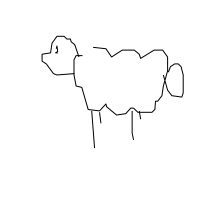

In [180]:
fig, ax = plt.subplots(figsize=(3, 3))

draw(a, ax=ax)

plt.show()

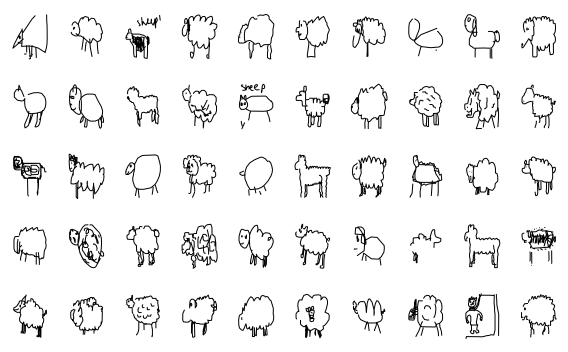

In [181]:
fig, ax_arr = plt.subplots(nrows=5, 
                           ncols=10, 
                           figsize=(8, 5),
                           subplot_kw=dict(xticks=[],
                                           yticks=[],
                                           frame_on=False))
fig.tight_layout()

for ax_row in ax_arr:
    for ax in ax_row:
        strokes = train_set.random_sample()
        draw(strokes, ax=ax)

plt.show()

#### Explanation

The last column of the 2D array is basically a binary value that gives the pen action for the *next* stroke in the sequence. 

In [159]:
a[::,-1].astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1])

In [160]:
all(StrokesPath.to_code(a[-1,-1]) == Path.MOVETO for a in train_set.strokes)

True

In [161]:
{c: getattr(Path, c) for c in dir(Path) if c.isupper()}

{'CLOSEPOLY': 79,
 'CURVE3': 3,
 'CURVE4': 4,
 'LINETO': 2,
 'MOVETO': 1,
 'NUM_VERTICES_FOR_CODE': {0: 1, 1: 1, 2: 1, 3: 2, 4: 3, 79: 1},
 'STOP': 0}

In [162]:
StrokesPath.to_code(a[::,-1].astype(int))

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 1])

### The real fun begins

In [111]:
# custom function to load model from local drive
def load_model(model_dir):
  """Loads environment for inference mode, used in jupyter notebook."""
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    model_config = json.load(f)
    model_params.update(model_config)

  model_params.batch_size = 1  # only sample one at a time
  eval_model_params = sketch_rnn_model.copy_hparams(model_params)
  eval_model_params.use_input_dropout = 0
  eval_model_params.use_recurrent_dropout = 0
  eval_model_params.use_output_dropout = 0
  eval_model_params.is_training = 0
  sample_model_params = sketch_rnn_model.copy_hparams(eval_model_params)
  sample_model_params.max_seq_len = 1  # sample one point at a time

  return model_params, eval_model_params, sample_model_params

In [112]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.


In [113]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [115]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, checkpoint_path=MODEL_DIR)

INFO:tensorflow:Loading model /tmp/sketch_rnn/models/aaron_sheep/layer_norm/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/aaron_sheep/layer_norm/vector


We define two convenience functions to encode a stroke into a latent vector, and decode from latent vector to stroke.

In [129]:
def encode(input_strokes):
  strokes = to_big_strokes(input_strokes).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
#   draw_strokes(to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]

In [130]:
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes

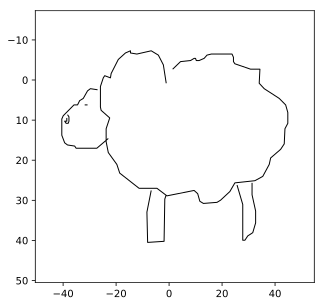

In [143]:
fig, ax = plt.subplots(figsize=(5, 5))

x_min, x_max, y_min, y_max = get_bounds(data=a, factor=.2)

ax.set_xlim(x_min-10, x_max+10)
ax.set_ylim(y_max+10, y_min-10)

strokes = StrokesPath(a)

patch = patches.PathPatch(strokes, facecolor='none')
ax.add_patch(patch)

plt.show()

Let's try to encode the sample stroke into latent vector $z$

In [144]:
z = encode(a)

In [157]:
b = decode(z, draw_mode=False, temperature=0.84) # convert z back to drawing at temperature of 0.8

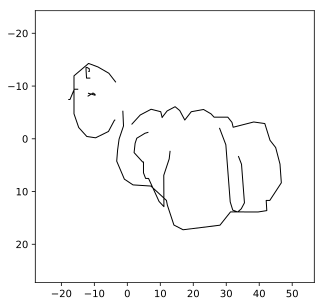

In [158]:
fig, ax = plt.subplots(figsize=(5, 5))

x_min, x_max, y_min, y_max = get_bounds(data=b, factor=.2)

ax.set_xlim(x_min-10, x_max+10)
ax.set_ylim(y_max+10, y_min-10)

strokes = StrokesPath(b)

patch = patches.PathPatch(strokes, facecolor='none')
ax.add_patch(patch)

plt.show()

Create generated grid at various temperatures from 0.1 to 1.0

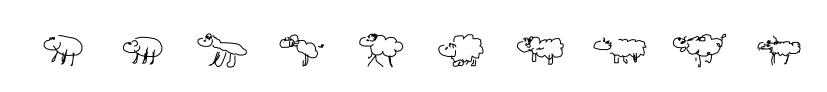

In [23]:
stroke_list = []
for i in range(10):
  stroke_list.append([decode(z, draw_mode=False, temperature=0.1*i+0.1), [0, i]])
stroke_grid = make_grid_svg(stroke_list)
draw_strokes(stroke_grid)

Latent Space Interpolation Example between $z_0$ and $z_1$

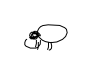

In [24]:
# get a sample drawing from the test set, and render it to .svg
z0 = z
_ = decode(z0)

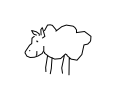

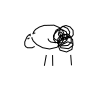

In [25]:
stroke = test_set.random_sample()
z1 = encode(stroke)
_ = decode(z1)

Now we interpolate between sheep $z_0$ and sheep $z_1$

In [26]:
z_list = [] # interpolate spherically between z0 and z1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z0, z1, t))

In [27]:
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False), [0, i]])

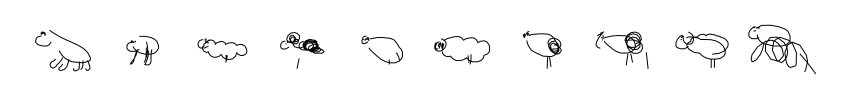

In [28]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Let's load the Flamingo Model, and try Unconditional (Decoder-Only) Generation

In [29]:
model_dir = '/tmp/sketch_rnn/models/flamingo/lstm_uncond'

In [30]:
[hps_model, eval_hps_model, sample_hps_model] = load_model(model_dir)

In [31]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.


In [32]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [33]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model /tmp/sketch_rnn/models/flamingo/lstm_uncond/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/flamingo/lstm_uncond/vector


In [34]:
# randomly unconditionally generate 10 examples
N = 10
reconstructions = []
for i in range(N):
  reconstructions.append([decode(temperature=0.5, draw_mode=False), [0, i]])

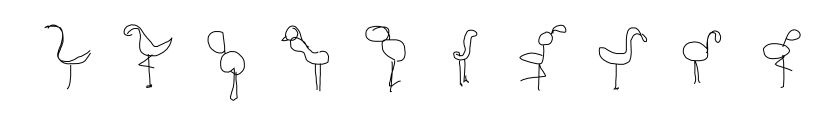

In [35]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Let's load the owl model, and generate two sketches using two random IID gaussian latent vectors

In [36]:
model_dir = '/tmp/sketch_rnn/models/owl/lstm'

In [37]:
[hps_model, eval_hps_model, sample_hps_model] = load_model(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Loading model /tmp/sketch_rnn/models/owl/lstm/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/owl/lstm/vector


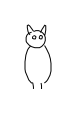

In [38]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

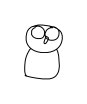

In [39]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

Let's interpolate between the two owls $z_0$ and $z_1$

In [40]:
z_list = [] # interpolate spherically between z_0 and z_1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.1), [0, i]])

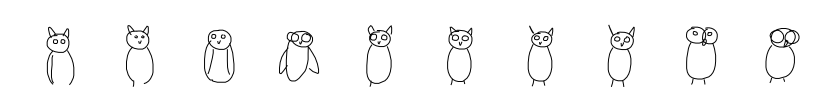

In [41]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Let's load the model trained on both cats and buses!  catbus!

In [42]:
model_dir = '/tmp/sketch_rnn/models/catbus/lstm'

In [43]:
[hps_model, eval_hps_model, sample_hps_model] = load_model(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Loading model /tmp/sketch_rnn/models/catbus/lstm/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/catbus/lstm/vector


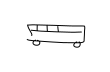

In [44]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

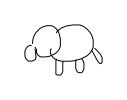

In [51]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

Let's interpolate between a cat and a bus!!!

In [52]:
z_list = [] # interpolate spherically between z_1 and z_0
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_1, z_0, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.15), [0, i]])

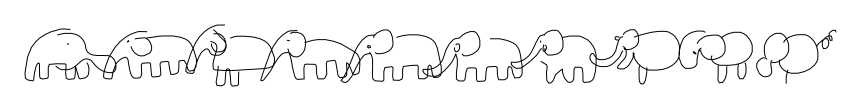

In [53]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Why stop here? Let's load the model trained on both elephants and pigs!!!

In [54]:
model_dir = '/tmp/sketch_rnn/models/elephantpig/lstm'

In [55]:
[hps_model, eval_hps_model, sample_hps_model] = load_model(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Loading model /tmp/sketch_rnn/models/elephantpig/lstm/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/elephantpig/lstm/vector


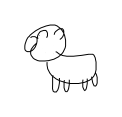

In [56]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

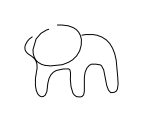

In [57]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

Tribute to an episode of [South Park](https://en.wikipedia.org/wiki/An_Elephant_Makes_Love_to_a_Pig): The interpolation between an Elephant and a Pig

In [58]:
z_list = [] # interpolate spherically between z_1 and z_0
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.15), [0, i]])

In [59]:
stroke_grid = make_grid_svg(reconstructions, grid_space_x=25.0)

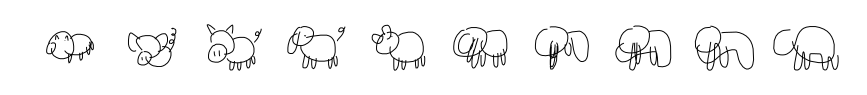

In [60]:
draw_strokes(stroke_grid, factor=0.3)